In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.extend([ '../', '../data'])
import torch
import torch.nn as nn
import torch.optim as optim
from data import input_data
import dataloader as dl
from args import Args
from model import Het_En, Classifier, EdgePredictor
from smote import smote
from train import train_smote, test_smote

# Set device to GPU if available, else use CPU
device = torch.device("cuda")
print(f"Current device: {torch.cuda.get_device_name(torch.cuda.current_device())}" if torch.cuda.is_available() else "Current device: CPU")
torch.cuda.empty_cache()

Current device: NVIDIA A100 80GB PCIe


In [2]:
args = Args() 
# data = input_data(args) 
# torch.save(data, 'data.pt')
data = torch.load('../data.pt')
print(data)

HeteroData(
  a={
    num_nodes=28645,
    y=[28645]
  },
  p={ num_nodes=21044 },
  v={ num_nodes=18 },
  p_title_embed={ x=[21044, 128] },
  p_abstract_embed={ x=[21044, 128] },
  p_net_embed={ x=[21044, 128] },
  p_a_net_embed={ x=[21044, 128] },
  p_p_net_embed={ x=[21044, 128] },
  p_v_net_embed={ x=[21044, 128] },
  a_net_embed={ x=[28645, 128] },
  a_text_embed={ x=[28645, 128] },
  v_net_embed={ x=[18, 128] },
  v_text_embed={ x=[18, 128] },
  (a, walk, a)={ edge_index=[2, 198912] },
  (a, walk, p)={ edge_index=[2, 144965] },
  (a, walk, v)={ edge_index=[2, 42500] },
  (p, walk, a)={ edge_index=[2, 137499] },
  (p, walk, p)={ edge_index=[2, 158408] },
  (p, walk, v)={ edge_index=[2, 29341] },
  (v, walk, a)={ edge_index=[2, 180] },
  (v, walk, p)={ edge_index=[2, 180] },
  (v, walk, v)={ edge_index=[2, 31] }
)


In [3]:
print(data['a','walk','p'].edge_index)

tensor([[    0,     0,     0,  ..., 28644, 28644, 28644],
        [11846, 11765, 12754,  ...,  4378, 20250,  6612]])


In [4]:
lr = 0.0001
num_epochs = 300
weight_decay = 5e-4
embed_dim = 128
dropout = 0.1
im_class_num = [1]
im_ratio = [0.5]
class_sample_num = 200
nclass = 4
node_dim = [args.A_n, args.P_n, args.V_n]

In [5]:
c_train_num = dl.train_num(data['a'].y, im_class_num, class_sample_num, im_ratio)
print(c_train_num, sum(c_train_num))
train_idx, val_idx, test_idx, c_num_mat = dl.segregate(data['a'].y, c_train_num)
print("train_idx: ", train_idx, len(train_idx))
print("val_idx: ", val_idx, len(val_idx))
print("test_idx: ", test_idx, len(test_idx))
# print(c_num_mat)

[200, 100, 200, 200] 700
0 3508
1 1946
2 2890
3 3016
train_idx:  [22397, 707, 10561, 11909, 7285, 9882, 19384, 6101, 13818, 4771, 28250, 28525, 5808, 11708, 24326, 18708, 2972, 16612, 22847, 26063, 16595, 923, 19683, 26951, 15910, 27159, 21241, 16211, 27046, 12194, 350, 23813, 940, 21697, 18900, 9708, 18258, 11315, 8103, 6941, 27216, 15000, 9394, 13701, 18051, 17727, 16893, 12932, 3443, 2070, 354, 10909, 19267, 10410, 26887, 13757, 16237, 16704, 7624, 22746, 19855, 23360, 25915, 11406, 24258, 852, 25343, 3967, 1533, 25939, 9276, 2746, 24917, 6392, 347, 3904, 11119, 3833, 5457, 22742, 24523, 17962, 1873, 11244, 14586, 23193, 13423, 22358, 2038, 14445, 1290, 12913, 28106, 1911, 5114, 17188, 20758, 13792, 14997, 26299, 3216, 25242, 2835, 26407, 18418, 1892, 15621, 20517, 21198, 14963, 17863, 15781, 23814, 15268, 16823, 18487, 15324, 16249, 3387, 23636, 15914, 4690, 15771, 7301, 6838, 8520, 27275, 15994, 17572, 13805, 20448, 6522, 4174, 27209, 22403, 26192, 11093, 17596, 22125, 10053, 9527

In [6]:
encoder = Het_En(node_dim, embed_dim, dropout)
decoder = EdgePredictor(embed_dim)
classifier = Classifier(embed_dim, nclass, dropout)
#print(features.shape)

In [7]:
# new_features, new_labels , new_train_idx = smote(features = data['a_net_embed'].x, labels = data['a'].y, 
#                                             train_idx = train_idx, portion = 0, im_class_num = im_class_num)
# print(new_features.shape, new_labels.shape, new_train_idx.shape)

## Training Part

In [8]:
torch.cuda.empty_cache()
train_smote(data, encoder, classifier, decoder, num_epochs, lr, weight_decay, train_idx, val_idx, portion = 0, im_class_num = im_class_num, mode = 'sm')

Epoch [1/300], Loss: 1.4877, Accuracy: 0.2258, Edge Accuracy: 0.5042
Class 0:AUC-ROC- 0.5186, F1 Score- 0.4103; Class 1:AUC-ROC- 0.5005, F1 Score- 0.3679; Class 2:AUC-ROC- 0.5596, F1 Score- 0.0000; Class 3:AUC-ROC- 0.4062, F1 Score- 0.0000; Macro-Average AUC-ROC: 0.4962,Macro-Average F1 Score: 0.1945
Validation Loss: 1.4865, Validation Accuracy: 0.2400, Validation Edge Accuracy: 0.5037
Class 0:AUC-ROC- 0.6107, F1 Score- 0.2182; Class 1:AUC-ROC- 0.4997, F1 Score- 0.1275; Class 2:AUC-ROC- 0.6278, F1 Score- 0.0000; Class 3:AUC-ROC- 0.3244, F1 Score- 0.0007; Macro-Average AUC-ROC: 0.5156,Macro-Average F1 Score: 0.0866
Epoch [2/300], Loss: 1.4853, Accuracy: 0.2503, Edge Accuracy: 0.5037
Class 0:AUC-ROC- 0.6671, F1 Score- 0.4103; Class 1:AUC-ROC- 0.6372, F1 Score- 0.3688; Class 2:AUC-ROC- 0.6224, F1 Score- 0.0000; Class 3:AUC-ROC- 0.4313, F1 Score- 0.0000; Macro-Average AUC-ROC: 0.5895,Macro-Average F1 Score: 0.1948
Validation Loss: 1.4841, Validation Accuracy: 0.2600, Validation Edge Accura

In [9]:
adj_old = torch.zeros((data['a'].num_nodes, data['a'].num_nodes), dtype = torch.float32)
adj_old[data['a', 'walk', 'a'].edge_index[0], data['a', 'walk', 'a'].edge_index[1]] = 1.0
test_smote(data, encoder, classifier, decoder, test_idx, adj_old = adj_old, mode = 'sm', dataset = "Test")

Test Loss: 0.3945, Test Accuracy: 0.9864, Test Edge Accuracy: 0.6570
Class 0:AUC-ROC- 0.9834, F1 Score- 0.4940; Class 1:AUC-ROC- 0.9846, F1 Score- 0.4362; Class 2:AUC-ROC- 0.9474, F1 Score- 0.3133; Class 3:AUC-ROC- 0.9794, F1 Score- 0.6670; Macro-Average AUC-ROC: 0.9737,Macro-Average F1 Score: 0.4776


(0.9863636363636363, 0.973699943981277, 0.4776263741608695)

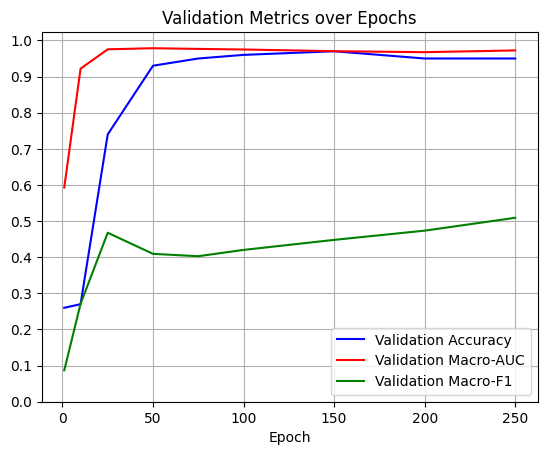

In [17]:
# Data
epochs = [1, 10, 25, 50, 75, 100, 150, 200, 250]
Val_acc_list = [0.26, 0.27, 0.74, 0.93, 0.95, 0.96, 0.97, 0.95, 0.95]
Val_auc_list = [0.5930095755030322, 0.9218978119106809, 0.9754136542837819, 0.9784269844215652, 0.9765362260372121, 0.974912021764024, 0.9702424321859386, 0.9674707975931053, 0.9723325504032536]
Val_f1_list = [0.08704139176217651, 0.2710137586280392, 0.4676582449091463, 0.40927857505690307, 0.4027379825175418, 0.42018465302397967, 0.4479509540242464, 0.47347841881981045, 0.5090739839801877]

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the data
ax.plot(epochs, Val_acc_list, label='Validation Accuracy', color='blue')
ax.plot(epochs, Val_auc_list, label='Validation Macro-AUC', color='red')
ax.plot(epochs, Val_f1_list, label='Validation Macro-F1', color='green')

# Add a legend
ax.legend()
ax.grid(True)

# Add labels and a title
ax.set_xlabel('Epoch')
ax.set_title('Validation Metrics over Epochs')

# Set y-axis ticks and labels
y_ticks = np.arange(0, 1.1, 0.1)  # Specify the tick positions
ax.set_yticks(y_ticks)            # Set the tick positions
#ax.set_yticklabels(['0.0', '0.1', '0.2', '0.3', '0.4', '0.43', '0.5', '0.6', '0.7', '0.8', '0.9', '0.95', '0.96', '1.0'])  # Set the tick labels

# Show the plot
plt.show()